In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [2]:
# import warnings; warnings.filterwarnings("ignore")
import numpy as np
from qiskit.circuit import QuantumCircuit, ParameterVector
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.algorithms import NumPyEigensolver
from qiskit.quantum_info import Pauli
#from qiskit.opflow import op_converter
#from qiskit.opflow import WeightedPauliOperator

/tmp/ipykernel_59/3074815191.py:10: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms import NumPyEigensolver


In [3]:
import networkx as nx
import itertools
# THE BELOW FUNCTION SOLVES MAXCUT USING CLASSICAL APPROACH
def maxcut_solver(graph):
    # Create a list of all possible node partitions
    all_partitions = list(itertools.product([0, 1], repeat=graph.number_of_nodes()))

    max_cut_size = 0
    best_partition = None

    for partition in all_partitions:
        cut_size = 0
        for edge in graph.edges:
            if partition[edge[0]] != partition[edge[1]]:
                cut_size += 1

        if cut_size > max_cut_size:
            max_cut_size = cut_size
            best_partition = partition

    return  max_cut_size




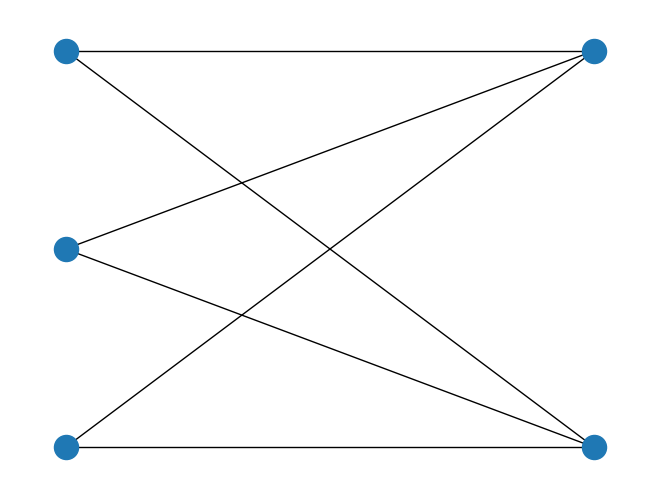

In [5]:
#INITIALIZING A MAXCUT GRAPH G AND DRAWING IT
G = nx.Graph()
G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])
nx.draw(G, pos=nx.bipartite_layout(G, [0,1,2]))

In [6]:
#CHECKING THE FUNCTION'S OPERATION
print(maxcut_solver(G))

6


In [7]:
#INITIALIZING FUNCTIONS FOR COST OPERATOR
def append_zz_term(qc, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1,q2)

def get_cost_operator_circuit(G, gamma):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for i, j in G.edges():
        append_zz_term(qc, i, j, gamma)
    return qc
    

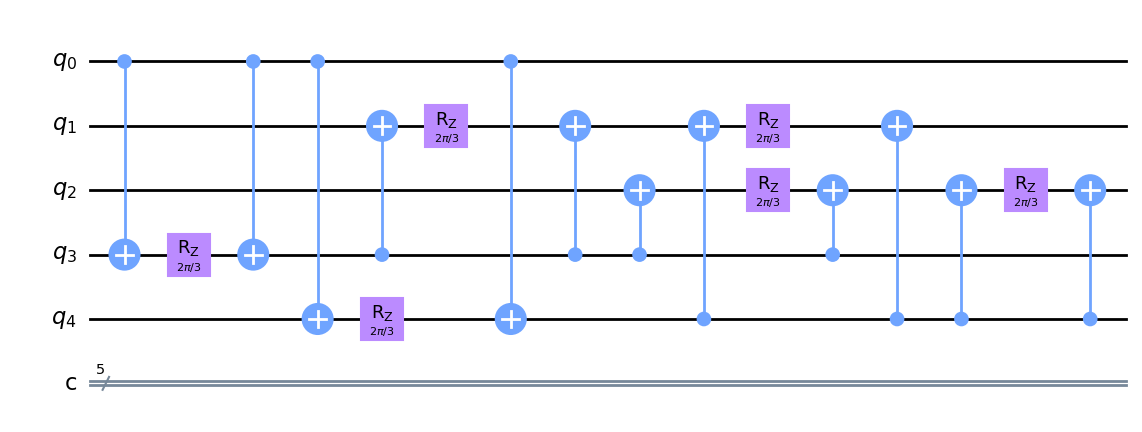

In [8]:
#CHECKING COST OPERATOR WITH DUMMY GAMMA
qc = get_cost_operator_circuit(G, np.pi / 3)

qc.draw()

In [9]:
#INITIALIZING FUNCTIONS FOR MIXER OPERATOR
def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)

def get_mixer_operator_circuit(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for n in G.nodes():
        append_x_term(qc, n, beta)
    return qc


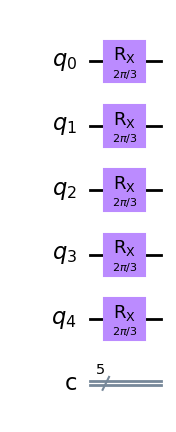

In [10]:
#CHECKING MIXER OPERATOR WITH DUMMY BETA
qc = get_mixer_operator_circuit(G, np.pi/3)
qc.draw()

In [11]:
#QAOA & QAOA+ CKTS
def get_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta)  # infer the number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N, N)
    
    # Apply a layer of Hadamards
    qc.h(range(N))
    
    # Apply p alternating operators
    for i in range(p):
        qc.compose(get_cost_operator_circuit(G, gamma[i]), inplace=True)
        qc.compose(get_mixer_operator_circuit(G, beta[i]), inplace=True)
    
    # Finally, measure the result
    qc.barrier(range(N))
    qc.measure(range(N), range(N))
    
    return qc

def get_qaoa_plus_circuit(G, beta, gamma,PHI):
    assert(len(beta) == len(gamma))
    p = len(beta)  # infer the number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N, N)
    
    # Apply a layer of Hadamards
    qc.h(range(N))
    
    # Apply p alternating operators
    for i in range(p):
        qc.compose(get_cost_operator_circuit(G, gamma[i]), inplace=True)
        qc.compose(get_mixer_operator_circuit(G, beta[i]), inplace=True)
    
    # Finally, measure the result
    qc.barrier(range(N))
    
    bind_dict = {}     # THESE LINES ASSIGNS THE PARAMETERS OF BETA AND GAMMA TO THE QAOA CIRCUIT
    phi = ParameterVector('φ',N)
    qc.parameters
    
    param =PHI #[beta:p,gamma:p,alpha:2**n]

    
    for i in range(N - 1):
    
        # THE BELOW LINES CONSTRUCTS THE PROBLEM INDEPENDENT LAYER WITH passed PARAMETERS 
        qc.crz(phi[i], i, i+1)
    qc.barrier()
    qc.x(range(N))


    for i, key in enumerate(qc.parameters):
        bind_dict[key] = param[i]

        
    qc = qc.bind_parameters(bind_dict)
    qc.measure(range(N), range(N))
    
    return qc

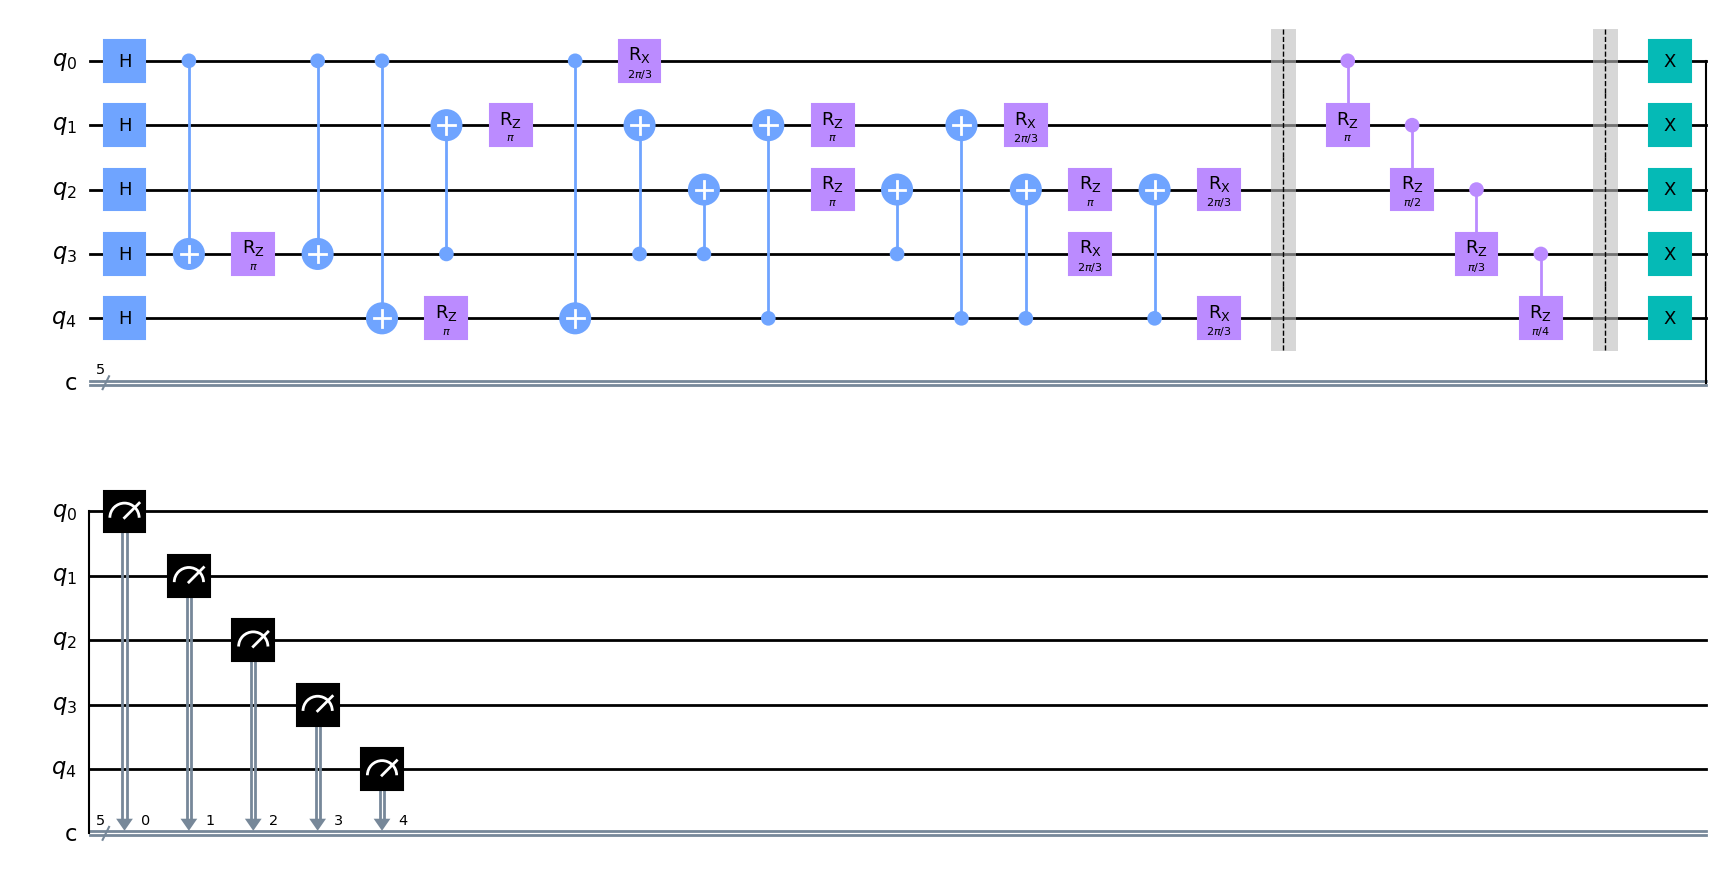

In [12]:
#CHECKING QAOA+ 
PHI = [np.pi/1,np.pi/2,np.pi/3,np.pi/4,np.pi/5]
qc = get_qaoa_plus_circuit(G,[np.pi/3], [np.pi/2],PHI)
qc.draw()

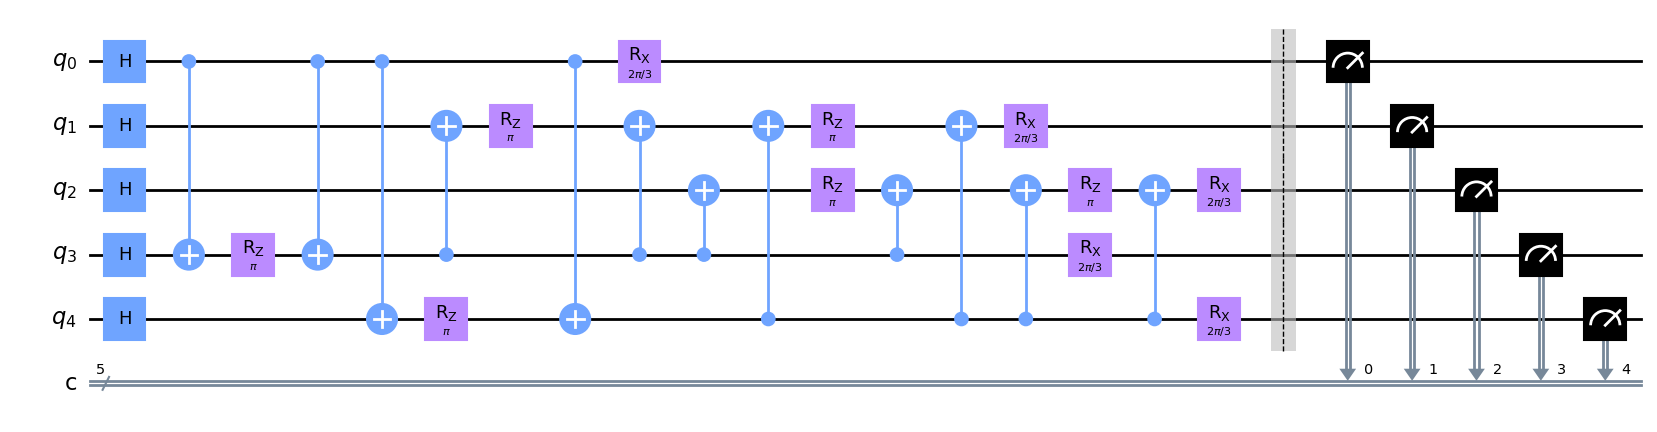

In [13]:
#CHECKING STANDAR QAOA 
qc = get_qaoa_circuit(G,[np.pi/3], [np.pi/2])
qc.draw()

In [14]:
#FUNCTION FOR MSB COUNT SAMPLING (NOT PART OF THE CKT JUST FOR INTERPRETATION)
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

In [15]:
#RUNNING THE JOB
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()
print(invert_counts(result.get_counts()))

{'01111': 31, '11110': 25, '00011': 25, '00001': 28, '11111': 26, '11011': 40, '00110': 42, '00010': 37, '10010': 34, '10001': 44, '10100': 34, '01011': 28, '00111': 28, '01100': 41, '10000': 42, '10101': 27, '01001': 32, '01101': 32, '11000': 30, '11100': 25, '10011': 21, '00000': 29, '00100': 40, '11001': 28, '01010': 35, '01110': 28, '10111': 36, '11010': 27, '11101': 39, '00101': 25, '10110': 32, '01000': 33}


In [16]:
#DEFINING MAXCUT OBJECTIVE FUNCTION
def maxcut_obj(x,G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            cut -= 1
    return cut

maxcut_obj('00011', G)

-6

In [17]:
#COMPUTES (supposedly) TOTAL ENERGY FRON THE SAMPLE SPACE 
def compute_maxcut_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

compute_maxcut_energy(invert_counts(result.get_counts()), G)

-2.9462890625

In [18]:
#INPUTS ANGLES ,COMPUTES GROUND STATES THEN RETURNS MIN ENERGY OR OPTIMAL COST
def get_black_box_objective(G,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G,beta, gamma)
        counts = execute(qc, backend, seed_simulator=10).result().get_counts()
        # return the energy
        return compute_maxcut_energy(invert_counts(counts), G)
    return f
def get_black_box_objective_plus(G,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        psi = len(theta)
        beta = theta[:p]
        gamma = theta[p:2*p]
        phi = theta[2*p:]
        qc = get_qaoa_plus_circuit(G,beta, gamma,phi)
        counts = execute(qc, backend, seed_simulator=10).result().get_counts()
        # return the energy
        return compute_maxcut_energy(invert_counts(counts), G)
    return f

In [19]:
#SOLVING MAXCUT USING STANDARD QAOA
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective(G, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':2500, 'disp': True})
res_sample


   Normal return from subroutine COBYLA

   NFVALS =  134   F =-5.297852E+00    MAXCV = 0.000000E+00
   X = 1.837494E+00   2.134594E+00   1.931953E+00   2.098630E+00   3.476310E-01
       2.046184E+00   6.112491E+00   2.317851E+00   3.564794E+00   5.872606E+00


     fun: -5.2978515625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 134
  status: 1
 success: True
       x: array([1.83749394, 2.1345936 , 1.9319531 , 2.09862998, 0.347631  ,
       2.04618358, 6.11249139, 2.31785137, 3.56479392, 5.87260613])

In [20]:
#SOLVING MAXCUT USING QAOA+
# p is the number of QAOA alternating operators

obj_plus = get_black_box_objective_plus(G, p)

init_point_plus = np.random.uniform(-0.001*np.pi, 0.001*np.pi, size=15)
# We are going to limit the number of iterations to 2500
res_sample_plus = minimize(obj_plus, init_point_plus, method='COBYLA', options={'maxiter':2500, 'disp': True})
res_sample_plus


   Normal return from subroutine COBYLA

   NFVALS =  175   F =-5.546875E+00    MAXCV = 0.000000E+00
   X = 1.197923E+00   3.549736E-01  -1.478372E-01   4.707367E-01   2.264238E-01
       5.508310E-01   1.284020E+00  -8.069294E-02   5.079954E-02  -1.246871E-01
       1.359845E-01   2.969118E-01   2.567457E-01   2.618870E-01  -1.646135E-01


     fun: -5.546875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 175
  status: 1
 success: True
       x: array([ 1.19792343,  0.35497361, -0.14783718,  0.47073671,  0.22642381,
        0.55083098,  1.28402027, -0.08069294,  0.05079954, -0.12468711,
        0.13598454,  0.29691177,  0.25674566,  0.26188701, -0.16461349])

In [21]:
optimal_theta = res_sample['x']
qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(execute(qc, backend).result().get_counts())
counts

{'11001': 1,
 '00101': 1,
 '00000': 2,
 '00110': 1,
 '01111': 4,
 '10111': 7,
 '00100': 5,
 '11010': 4,
 '01000': 2,
 '11100': 375,
 '11000': 23,
 '11110': 26,
 '00011': 377,
 '01110': 2,
 '10010': 1,
 '01011': 19,
 '10100': 18,
 '10001': 3,
 '10000': 2,
 '01001': 1,
 '00111': 26,
 '11101': 24,
 '00001': 25,
 '11011': 2,
 '10011': 20,
 '00010': 28,
 '01100': 25}

<BarContainer object of 5 artists>

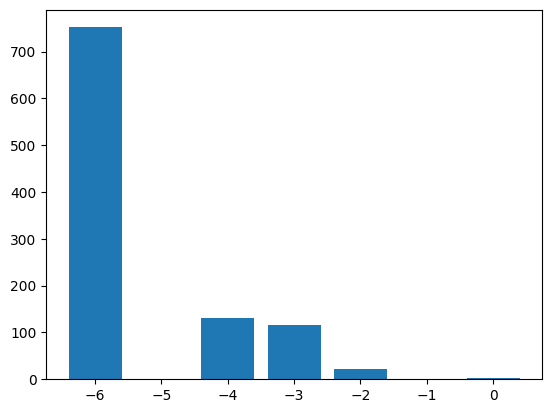

In [22]:
energies = defaultdict(int)
for k, v in counts.items():
    energies[maxcut_obj(k,G)] += v

x,y = zip(*energies.items())
plt.bar(x,y)


In [24]:
#DISPLAYING RESULTS
obtained_cost_qaoa = -1*res_sample['fun']
obtained_cost_plus = -1*res_sample_plus['fun']
correct_cost_qaoa = maxcut_solver(G)
App_ratio_qaoa= obtained_cost_qaoa/correct_cost_qaoa
App_ratio_plus= obtained_cost_plus/correct_cost_qaoa

print("App_ratio_qaoa,App_ratio_plus",App_ratio_qaoa,App_ratio_plus)

App_ratio_qaoa,App_ratio_plus 0.8829752604166666 0.9244791666666666
